In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = pd.read_csv('Phishing Websites Preprocessed.csv')

#Feature Engineering

In [14]:
# 1. Link-based aggregate
df['total_link_flags'] = (
    df['request_url'].astype(int) +
    df['url_of_anchor'].astype(int) +
    df['links_in_tags'].astype(int) +
    df['statistical_report'].astype(int)
)

In [15]:
# 2. Security indicators score
df['security_score'] = (
    df['sslfinal_state'].astype(int) +
    df['https_token'].astype(int) +
    df['google_index'].astype(int) +
    df['dnsrecord'].astype(int) +
    df['web_traffic'].astype(int) +
    df['page_rank'].astype(int)
) / 6

In [16]:
# 3. Obfuscation score
df['obfuscation_score'] = (
    df['having_at_symbol'].astype(int) +
    df['prefix_suffix'].astype(int) +
    df['having_sub_domain'].astype(int) +
    df['url_length'].astype(int) +
    df['https_token'].astype(int)
)

In [17]:
# 4. Technical complexity score
df['tech_complexity'] = (
    df['sfh'].astype(int) +
    df['iframe'].astype(int) +
    df['rightclick'].astype(int) +
    df['on_mouseover'].astype(int) +
    df['submitting_to_email'].astype(int)
)

In [18]:
df[['total_link_flags', 'security_score', 'obfuscation_score', 'tech_complexity']].head()

,total_link_flags,security_score,obfuscation_score,tech_complexity
0,0,-0.666667,-1,1
1,1,-0.166667,0,3
2,-1,-0.333333,-2,1
3,0,-0.333333,-2,3
4,2,0.166667,2,1


In [19]:
df.head()

,having_ip_address,url_length,shortining_service,having_at_symbol,double_slash_redirecting,prefix_suffix,having_sub_domain,sslfinal_state,domain_registration_length,favicon,...,web_traffic,page_rank,google_index,links_pointing_to_page,statistical_report,target,total_link_flags,security_score,obfuscation_score,tech_complexity
0,-1,1,1,1,-1,-1,-1,-1,-1,1,...,-1,-1,1,1,-1,-1,0,-0.666667,-1,1
1,1,1,1,1,1,-1,0,1,-1,1,...,0,-1,1,1,1,-1,1,-0.166667,0,3
2,1,0,1,1,1,-1,-1,-1,-1,1,...,1,-1,1,0,-1,-1,-1,-0.333333,-2,1
3,1,0,1,1,1,-1,-1,-1,1,1,...,1,-1,1,-1,1,-1,0,-0.333333,-2,3
4,1,0,-1,1,1,-1,1,1,-1,1,...,0,-1,1,1,1,1,2,0.166667,2,1


#Feature Selection

In [20]:
from sklearn.feature_selection import SelectKBest, f_classif, chi2, mutual_info_classif, VarianceThreshold, mutual_info_classif
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [21]:
X = df.drop(columns=['target'])
y = df['target']

## 1. Variance Threshold

In [22]:
selector_variance = VarianceThreshold(threshold=0.1)
X_var = selector_variance.fit_transform(X)
selected_features_var = X.columns[selector_variance.get_support()].tolist()
variance_scores = pd.DataFrame({
    'Feature': X.columns,
    'Variance': selector_variance.variances_
}).sort_values('Variance', ascending=False)

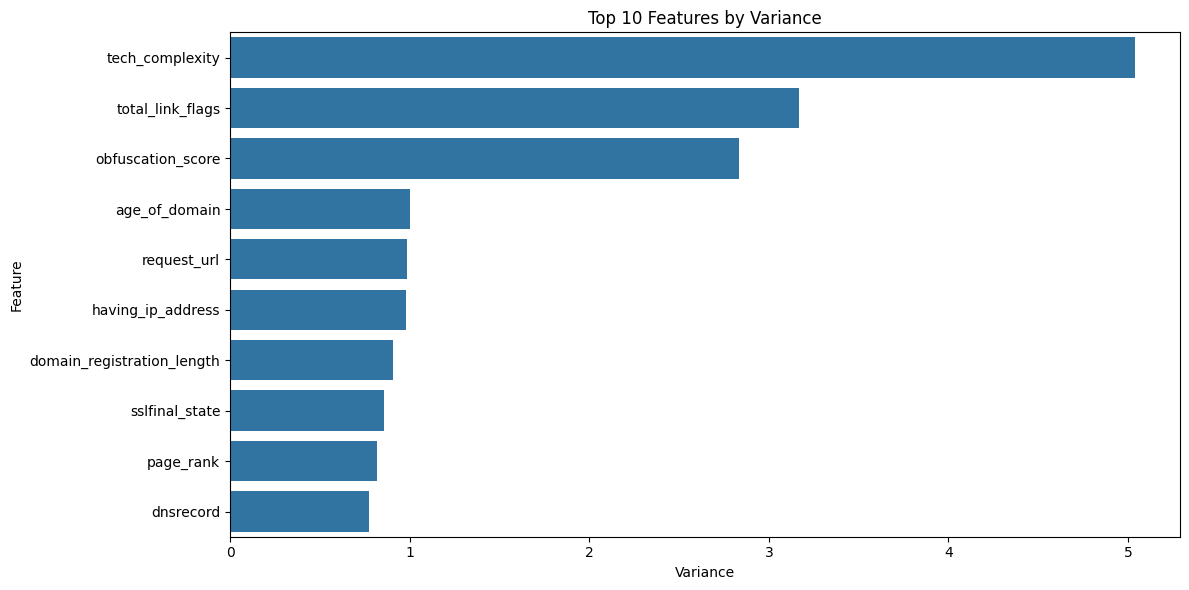

Features with zero variance: set()



In [23]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Variance', y='Feature', data=variance_scores.head(10))
plt.title('Top 10 Features by Variance')
plt.tight_layout()
plt.show()
print(f"Features with zero variance: {set(X.columns) - set(selected_features_var)}\n")

## 2. Chi-square Test

In [24]:
minmax_scaler = MinMaxScaler()
X_non_negative = minmax_scaler.fit_transform(X)
y_bin = np.where(y > np.median(y), 1, 0)

In [25]:
chi2_scores, _ = chi2(X_non_negative, y_bin)
chi2_scores = pd.Series(chi2_scores, index=X.columns)
chi2_scores.sort_values(ascending=False, inplace=True)

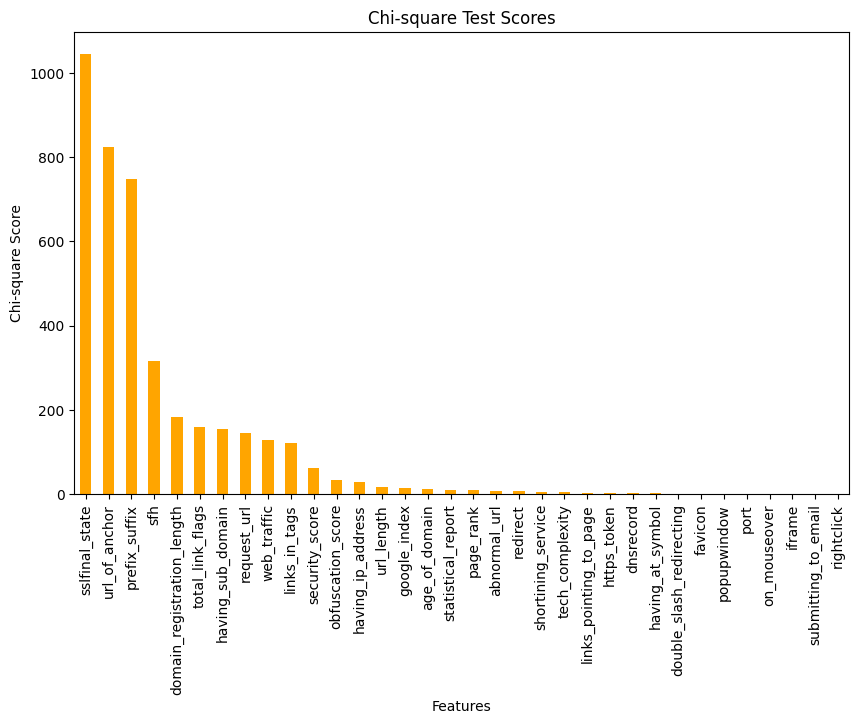

In [26]:
plt.figure(figsize=(10, 6))
chi2_scores.plot(kind="bar", color="orange")
plt.title("Chi-square Test Scores")
plt.xlabel("Features")
plt.ylabel("Chi-square Score")
plt.show()

## 3. ANOVA F-test

In [27]:
f_scores, _ = f_classif(X, y)  # ANOVA F-test
f_scores = pd.Series(f_scores, index=X.columns)
f_scores.sort_values(ascending=False, inplace=True)

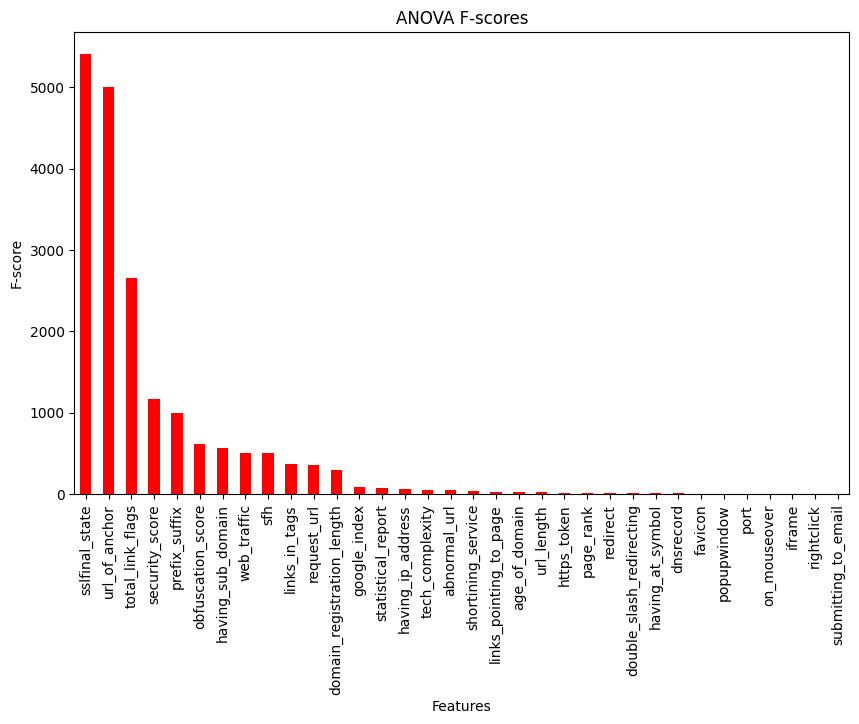

In [28]:
plt.figure(figsize=(10, 6))
f_scores.plot(kind="bar", color="red")
plt.title("ANOVA F-scores")
plt.xlabel("Features")
plt.ylabel("F-score")
plt.show()

## 4. Mutual Information

In [29]:
selector_mi = SelectKBest(mutual_info_classif, k=10)
X_mi_selected = selector_mi.fit_transform(X, y)
mi_scores = pd.DataFrame({
    'Feature': X.columns,
    'MI Score': selector_mi.scores_
}).sort_values('MI Score', ascending=False)

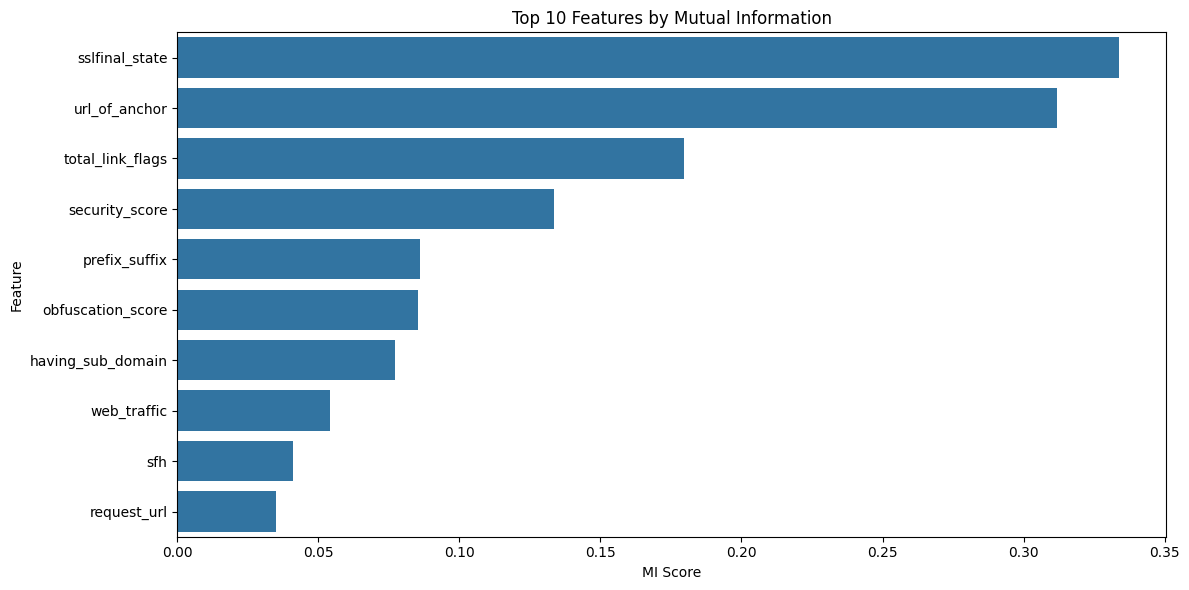

              Feature  MI Score
7      sslfinal_state  0.333705
13      url_of_anchor  0.311922
30   total_link_flags  0.179520
31     security_score  0.133581
5       prefix_suffix  0.086072
32  obfuscation_score  0.085203
6   having_sub_domain  0.077167
25        web_traffic  0.054234
15                sfh  0.041063
12        request_url  0.034837


In [30]:
plt.figure(figsize=(12, 6))
sns.barplot(x='MI Score', y='Feature', data=mi_scores.head(10))
plt.title('Top 10 Features by Mutual Information')
plt.tight_layout()
plt.show()
print(mi_scores.head(10))

## 5. Fisher's Score

In [31]:
def fisher_score(X, y):
    classes = np.unique(y)
    overall_mean = np.mean(X, axis=0)
    between_var = np.zeros(X.shape[1])
    within_var = np.zeros(X.shape[1])

    for c in classes:
        X_c = X[y == c]
        mean_c = np.mean(X_c, axis=0)
        n_c = X_c.shape[0]

        between_var += n_c * (mean_c - overall_mean) ** 2
        within_var += np.sum((X_c - mean_c) ** 2, axis=0)

    fisher_scores = between_var / within_var
    return fisher_scores

In [32]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [33]:
fisher_scores = fisher_score(X_scaled, y_bin)  # Using binarized target
fisher_scores = pd.Series(fisher_scores, index=X.columns)
fisher_scores.sort_values(ascending=False, inplace=True)

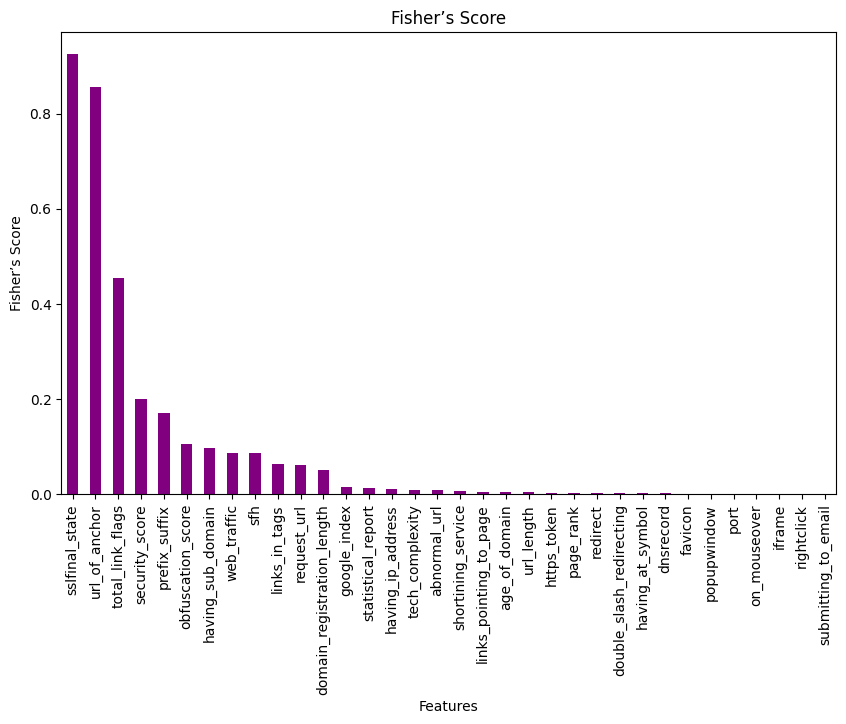

In [34]:
plt.figure(figsize=(10, 6))
fisher_scores.plot(kind="bar", color="purple")
plt.title("Fisher’s Score")
plt.xlabel("Features")
plt.ylabel("Fisher’s Score")
plt.show()

In [35]:
## 6. Correlation Coefficient

In [36]:
corr_scores = np.corrcoef(X.T, y)[-1, :-1]  # Correlation with target
corr_scores = pd.Series(corr_scores, index=X.columns)
corr_scores.sort_values(ascending=False, inplace=True)

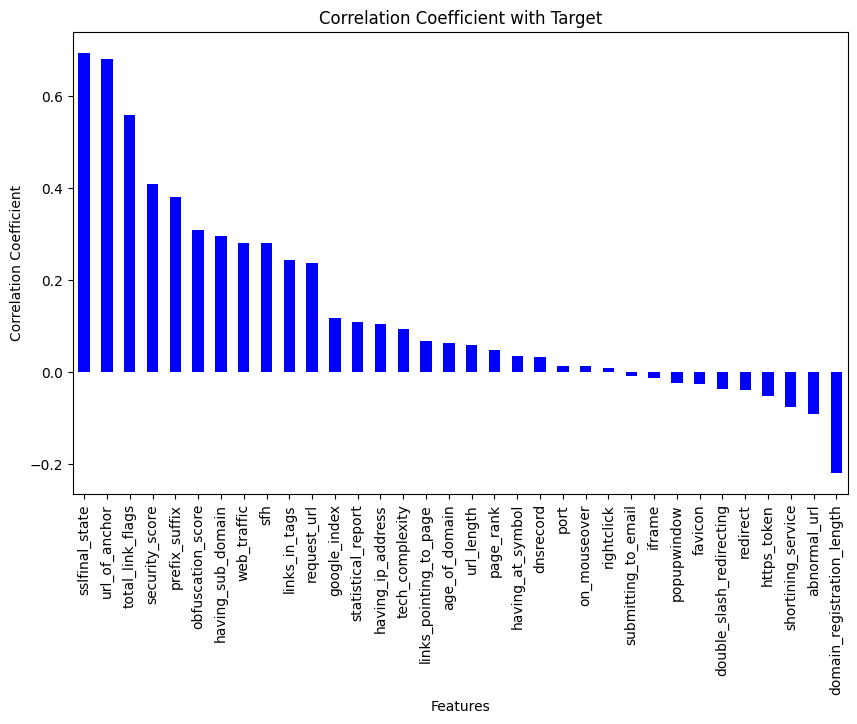

In [37]:
plt.figure(figsize=(10, 6))
corr_scores.plot(kind="bar", color="blue")
plt.title("Correlation Coefficient with Target")
plt.xlabel("Features")
plt.ylabel("Correlation Coefficient")
plt.show()

In [38]:
df.to_csv('Phishing Websites Engineered.csv', index=False)